# Taller 2. Simulador de vuelta de kart#

### Camilo Garcia 201417471 ###

A continuacion se empezara definiendo las funciones necesarias para la realizacion de la simulacion del kart
electrico.

## Objetivos ##

- Generar funciones para predecir el comportamiento del carro acelerando hasta una velocidad maxima
- Generar funciones para predecir el comportamiento del carro frenando desde velocidad maxima hasta velocidad 0
- Calcular la velocidad maxima alcanzada por el carro
- Calcular la distancia recorrida por el carro desde que inicia a velocidad cero, acelera hasta velocidad maxima y vuelve a llegar a velocidad cero.
- Analizar el efecto de los parametros (masa, eficiencia, relacion de transimision) del kart en terminos de aceleracion, velocidad maxima

## Definicion de parametros ##


<div style="text-align: justify"> A continuacion se definen las constantes del Kart. Se utilizaran las dimensiones medidas por Mariana. En la siguiente seccion se definiran los parametros como: Masas, radios, radio efectivo, masa efectiva , relacion de transmision, eficiencia de transmision, momentos de inercia entre otros. El valor de relacion de transmision se puede cambiar al valor calculado por clavijo. </div>

In [1]:

%pylab inline
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt


rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)

# Datos Transmisión
dp=11 # Dientes del piñon
dpl=39 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)

mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)
 

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

gamma = 1 # aceleracion

# Aceleración, Fuerza de tracción
mr=((((ii-ig)*ng**2))+ieje+illd*2+illt*2)/(refc**2)


Populating the interactive namespace from numpy and matplotlib


## Funciones ##


<div style="text-align: justify"> Esta es la seccion de funciones.  La siguiente seccion se definiran todas las funciones necesarias para predecir el comportamiento del carro tanto en aceleracion como en frenado. Esta seccion se compone de 3 partes: Fuerzas; acelerado y frenado; medicion de tiempo, velocidad, aceleracion y graficas. </div>


### Primer parte ###
<div style="text-align: justify"> La primer parte se compone de la definicion de las fuerzas, necesarias para el modelo dinamico de aceleracion y frenado. Entre las funciones definidas esta fuerza de rodadura (con velocidad constante y con aceleracion, fuerza de arraste, fuerza de traccion, la funcion que devuelve la velocidad angular del motor en rad/s , la funcion potencia que mide la potencia den entrega del motor, y la funcion torque que entrega el torque del motor </div>





In [2]:
def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr # (N)

def frodadura_const(vx):
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return w*fr # (N)

def farrastre(vx):
    return (0.5)*rho*af*cd*(vx)**2 # (N)

def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

def ftraccion2(ax):
    Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng**2)+ieje+illd*2+illt*2)*(ax/(refc**2)) # (N)
    return FT


def omega(vx):
    x=(vx*ng)/refc
 
    if x>=523.6:
        x=523.6
    
    
    return x # (rad/s)



def potencia(vx):
    o=omega(vx)
    omega1=o*(60/(2*pi))
    #p=((-0.00000004564538677*omega1**3)+(0.0001056995459*omega1**2)+(1.53209191*omega1)-(12.895523696))
    p=((-3.6E-8*omega1**3)+(2.99E-5*omega1**2)+(1.53209191*omega1)-(0.595523696))

        
    return p

def torque(vx):
    p=potencia(vx)
    o=omega(vx)

    t=p/o
    
    if o<=1.0:
        t=1.5
        
    return t

### Segunda Parte ###

<div style="text-align: justify"> En la segunda parte se define la funcion a el cual utiliza las funciones de fuerza para modelar el comportamiento del carro acelerando desde velocidad cero a velocidad maxima. En en el mismo orden de ideas, se defina la funcion afrenado la cual tambien utiliza las funciones de fuerza de la primer parte. </div>


A continuacion se presenta la funcion de aceleracion del Kart, la ecuacion utilizada se expondra a cotinuacion:

$$a_x=(\frac{T_e N_c \mu }{r_e}-R_x-D_a)\frac{1}{M+M_r}$$

Donde ax es la aceleracion del carro, T_e el torque del motor, N_c la relacion de transimicion, \mu la eficiencia den transmicion, r_e el radio efectivo de las llantas, Rx la fuerza de rodadura, D_a la fuerza de arrastre, M la masa del kart y M_r es la masa efectiva de las otras partes del Kart.

- <div style="text-align: justify"> Para resolver la ecuacion diferencial se utilizara la funcion ODEIN. Para que esta funcion sirva es necesario que la funcion tenga 2 parametros de entrada, posicion y tiempo. Como consecuencia esta funcion retornara un array de velocidad y aceleracion </div>


In [3]:
def a(x1,t):
    x1, v1=x1
    a=(torque(v1)*ng*etaf*(1/refc)-frodadura_const(v1)-farrastre(v1))*(1/(masa+mr))

   
    dxdt=[v1,a]
    return dxdt

En el mismo orden de ideas, se define la funcion de frenado del Kart, la ecuacion del modelo de frenado es igual a:

$$a_f=(-\frac{T_f}{r_e}-R_x-D_a)\frac{1}{M+M_r}$$

<div style="text-align: justify"> Donde a_f es la aceleracion de frenado y la relacion T_f/t_ef es la fuerza de frenado, cabe resaltar la diferencia de signos en esta ecuacion con la anterior. En la ecuacion anterior, la fuerza generada por el torque es positiva y las demas fuerzas negativas porque impiden la aceleracion del motor. Mientras que en esta ecuacion todas las fuerzas son negativas y ayudan al frenado. Otro punto a resaltar es que no se toma encuenca ni la relacion de transmicion ni la eficiencia de transmicion debido a que la fuerza de frenado se aplica directamente a las llantas traseras. </div>

- <div style="text-align: justify"> La funcion de frenado tambien tendra 2 parametros de entrada, posicion y tiempo; y retornara velocidad y aceleracion. La funcion final sera:</div>

In [4]:
def afrenado(x1, t):
    x, v1=x1
    
    if v1<=0:
        dxdt=[0,0]
        return dxdt
        
    af=((-17*(1/refc)-frodadura_const(v1)-farrastre(v1))*(1/(masa+mr)))
    ##af=((-420+frodadura_const(v1)+farrastre(v1))*(1/(masa+mr)))
    
    
    
        
    

    dxdt=[v1,af]
    return dxdt

In [125]:
x0 =[0,0.1]

t = linspace(0, 100, 100)
t2 = linspace (100, 150, 100)

integral=odeint(a,x0,t)

x1=[np.max(integral[:,0]),np.max(integral[:,1])]
integral2=odeint(afrenado,x1,t2)

### Tercera Parte: ###

<div style="text-align: justify"> En esta ultima parte se define la funcion acelerar y frenar la cual tiene varios objetivos: medir la distancia total recorrida por el kart desde que inicia con velocidad cero, alcanza velocidad maxima y vuelve a velocidad cero, medir el tiempo de este proceso, medir la velocidad maxima, calcular la aceleracion promedio desde velocidad cero hasta velocidad maxima (acelerando), y tambien la aceleracion promedio desde velocidad maxima a cero (frenando).</div>

- <div style="text-align: justify">Esta funcion no tiene ningun aprametro de entrada, pero si utiliza la funcion ODEIN, la cual recibe como entrada una funcion, un vector con valores iniciales de posicion y velocidad y un vector de tiempo. La funcion resolvera la ecuacion diferencial y retornara un array de posicion y velocidad. </div>

In [6]:
def aceleraryfrenar():
    
    
    t0 = linspace(0, 10, 100)
    x0=[0,0.1]
    integral0=odeint(a,x0,t0)
   
    for tiempo in range (0, 200):
        t1=linspace(tiempo*10+10, tiempo*10+15, 100)
        x1=[integral0[-1,0],integral0[-1,1]]
        integral0=odeint(a,x1,t1)
        
        
        if (integral0[-1,1]-integral0[-2,1])<=0.001:
            
            tacel=linspace(0, tiempo*10+10, 100)
            vmax=integral0[-1,1]
            acelproma=integral0[-1,1]/(tiempo*10+10)
            integralacel=odeint(a,x0,tacel)
            x2=[np.max(integralacel[:,0]),np.max(integralacel[:,1])]
            t2=linspace(tiempo*10+10, tiempo*10+15, 100)
            integral2=odeint(afrenado,x2,t2)
            
            for tiempo2 in range (0,200):
                t3 = linspace(10*tiempo+tiempo2+15, 10*tiempo+tiempo2+16, 100)
                x3=[integral2[-1,0],integral2[-1,1]]
                integral2=odeint(afrenado,x3,t3)
                
                if integral2[-1,1]<=0.1:
                    tiempototal=10*tiempo+tiempo2+16
                    acelpromf=integral0[-1,1]/tiempo2+6
                    break
                
            tfren=linspace(tiempo*10+10, 10*tiempo+100, 100)
            integralfren=odeint(afrenado,x2,tfren)
            break
            
    graficaacel=plt.plot(tacel, integralacel[:, 1], 'g', label='velocidad acel(m/s)')
    graficafren=plt.plot(tfren, integralfren[:, 1], 'k', label='velocidad frenado(m/s)')
    plt.legend(loc='best')
    plt.xlabel('t (s)')
    plt.ylabel('vel (m/s)')
    plt.grid()
    plt.show()
    
    return graficaacel, graficafren

In [7]:
def resultados():
    
    
    t0 = linspace(0, 10, 100)
    x0=[0,0.1]
    integral0=odeint(a,x0,t0)
   
    for tiempo in range (0, 200):
        t1=linspace(tiempo*10+10, tiempo*10+15, 100)
        x1=[integral0[-1,0],integral0[-1,1]]
        integral0=odeint(a,x1,t1)
        
        
        if (integral0[-1,1]-integral0[-2,1])<=0.001:
            
            tacel=linspace(0, tiempo*10+10, 100)
            vmax=integral0[-1,1]
            acelproma=integral0[-1,1]/(tiempo*10+10)
            integralacel=odeint(a,x0,tacel)
            x2=[np.max(integralacel[:,0]),np.max(integralacel[:,1])]
            t2=linspace(tiempo*10+10, tiempo*10+15, 100)
            integral2=odeint(afrenado,x2,t2)
            
            for tiempo2 in range (0,200):
                t3 = linspace(10*tiempo+tiempo2+15, 10*tiempo+tiempo2+16, 100)
                x3=[integral2[-1,0],integral2[-1,1]]
                integral2=odeint(afrenado,x3,t3)
                
                if integral2[-1,1]<=0.1:
                    tiempototal=10*tiempo+tiempo2+16
                    acelpromf=integral0[-1,1]/tiempo2+6
                    break
                
            tfren=linspace(tiempo*10+10, 10*tiempo+100, 100)
            integralfren=odeint(afrenado,x2,tfren)
            break
            
    mensaje='el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',tiempototal,'segundos'
    mensaje2='La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es', integralfren[-1,0],'m'
    mensaje3='La velocidad maxima del kart es', vmax, 'm/s'
    mensaje4='La aceleracion promedio en la primer etapa es', acelproma,'m^2/s'
    mensaje5='La aceleracion promedio en la segunda etapa es', acelpromf,'m^2/s'
    return  mensaje, mensaje2, mensaje3, mensaje4, mensaje5
                    

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


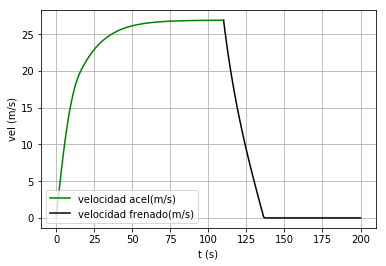

([<matplotlib.lines.Line2D at 0x15145bd668>],
 [<matplotlib.lines.Line2D at 0x15145bd8d0>])

In [8]:
aceleraryfrenar()

In [126]:
resultados()

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  140,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  3540.4226308661678,
  'm'),
 ('La velocidad maxima del kart es', 32.24735132661624, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.29315773933287492,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.3436396386090097,
  'm^2/s'))

## Analisis ##

### VARIACION DE PARAMETROS PARA EL KART PARA ACELERACION ##
### MASA: ###

In [85]:
#masa= 152
#masa= 160
masa= 140

ng=3.4
cd=0.89


In [82]:
masa1=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
amasa1=odeint(a,x0,t0)
masa1

(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  137,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  2865.3710228445079,
  'm'),
 ('La velocidad maxima del kart es', 26.05048875203849, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.23682262501853171,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.2404994643827854,
  'm^2/s'))

In [84]:
masa2=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
amasa2=odeint(a,x0,t0)
masa2

(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  148,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  3127.2700645359014,
  'm'),
 ('La velocidad maxima del kart es', 26.085005426399061, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.21737504521999218,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.1856820648363211,
  'm^2/s'))

In [86]:
masa3=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
amasa3=odeint(a,x0,t0)
masa3

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  137,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  2867.3440042683069,
  'm'),
 ('La velocidad maxima del kart es', 26.121345588231275, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.23746677807482977,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.2438735994395849,
  'm^2/s'))

A continuacion se presenta una tabla con los valores de la variacion de masas:
    
| Masa Kart (kg)        | 140  | 152  | 160  |
|-----------------------|------|------|------|
| Vmax (m/s)            | 26.0 | 26.0 | 26.1 |
| Distancia total (km)* | 2.8  | 2.8  | 3.1  |

<div style="text-align: center">**Tabla 1. Variacion de velocidad maxima y distancia total para diferentes parametros de masa** </div>

Como podemos ver. Para una variacion de alrededor de 10kg del Kart, ya sea por la el cambio del piloto (uno con mayor o menor masa), cambio de baterias u otra razon esto no afecta de manera significativa la velocidad maxima de aceleracion del kart. La diferencia maxima es de 0.1 m/s. Se procedera a graficar las graficas con diferentes valores de masa.

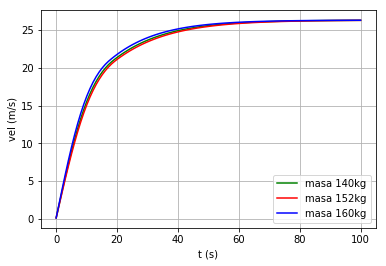

In [87]:
g1=plt.plot(t0, amasa1[:, 1], 'g', label='masa 140kg')
g2=plt.plot(t0, amasa2[:, 1], 'r', label='masa 152kg')
g3=plt.plot(t0, amasa3[:, 1], 'b', label='masa 160kg')

plt.legend(loc='best')
plt.xlabel('t (s)')
plt.ylabel('vel (m/s)')
plt.grid()
plt.show()

<div style="text-align: left">**Grafica 1. Variacion de velocidad maxima y distancia total para diferentes parametros de masa** </div>

Como podemos ver de la anterior grafica y a tabla de resultados, la masa no afecta de manera significativa la velocidad del kart. En general la velocidad no vario mas de 0.1 m/s para una variacion de alrededor de 10 kg. Las otras fuerzas que afectan el modelo dinamico tienen mas peso en la ecuacion utilizada.

### RELACION DE TRANSMISION:###

In [134]:
masa= 152
cd=0.89
ng=3 
#ng=4
#ng=5



(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  137,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  2865.3710228445079,
  'm'),
 ('La velocidad maxima del kart es', 26.05048875203849, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.23682262501853171,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.2404994643827854,
  'm^2/s'))

In [135]:
ng1=resultados()
x1 =[0,0.1]
t1 = linspace(0, 100, 100)
ang1=odeint(a,x1,t1)
ng1

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  140,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  3540.4226308661678,
  'm'),
 ('La velocidad maxima del kart es', 32.24735132661624, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.29315773933287492,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.3436396386090097,
  'm^2/s'))

In [92]:
ng2=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
ang2=odeint(a,x0,t0)
ng2

(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  148,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  3412.8292375962942,
  'm'),
 ('La velocidad maxima del kart es', 28.583106175540177, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.2381925514628348,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es', 7.29923209888819, 'm^2/s'))

In [94]:
ng3=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
ang3=odeint(a,x0,t0)
ng3

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  140,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  3540.4226308661678,
  'm'),
 ('La velocidad maxima del kart es', 32.24735132661624, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.29315773933287492,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.3436396386090097,
  'm^2/s'))

A continuacion se presenta una tabla con los valores de la variacion de relacion de transmicion ng:
    
| Relacion de transmision| 3    | 4    | 5    |
|------------------------|------|------|------|
| Vmax (m/s)             | 24.3 | 28.5 | 32.2 |
| Distancia total (km)*  | 2.21 | 3.41 | 3.54 |

<div style="text-align: center">**Tabla 1. Variacion de velocidad maxima y distancia total para diferentes parametros de masa** </div>

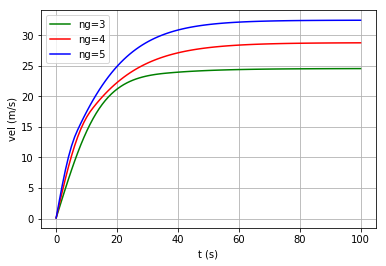

In [95]:
g1=plt.plot(t0, ang1[:, 1], 'g', label='ng=3')
g2=plt.plot(t0, ang2[:, 1], 'r', label='ng=4')
g3=plt.plot(t0, ang3[:, 1], 'b', label='ng=5')

plt.legend(loc='best')
plt.xlabel('t (s)')
plt.ylabel('vel (m/s)')
plt.grid()
plt.show()

<div style="text-align: left">**Grafica 2. Variacion de velocidad maxima y distancia total para diferentes parametros de relacion de transmicion** </div>


De la tabla de resultados podemos ver que el relacion de transmision afecta de manera significativa el desempeño del kart. Entre mayor relacion de transmision, mayor velocidad tope y mayor distancia recorrida en menos tiempo. Variando la relacion en 1 unidad genera una diferencia entre de velocidades tope del 17.3% o mas o menos 3.5m/s.

### COEFIEIENTE DE ARRASTRE ###

In [46]:
masa= 152
ng=3.4
cd=0.8
#cd=0.85
#cd=0.89

In [47]:
cd1=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
acd1=odeint(a,x0,t0)
cd1

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  148,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  3282.9572074553375,
  'm'),
 ('La velocidad maxima del kart es', 27.457759069831685, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.22881465891526404,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.2480799577196215,
  'm^2/s'))

In [42]:
cd2=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
acd2=odeint(a,x0,t0)
cd2

(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  147,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  3194.3718392015953,
  'm'),
 ('La velocidad maxima del kart es', 26.695177432363984, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.22245981193636652,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.2711989253506655,
  'm^2/s'))

In [44]:
cd3=resultados()
x0 =[0,0.1]
t0 = linspace(0, 100, 100)
acd3=odeint(a,x0,t0)
cd3

(('el tiempo desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  137,
  'segundos'),
 ('La distancia desde proceso de arrancada desde cero, llegar a velocidad máxima y frenar a velocidad cero es',
  2865.3710228445079,
  'm'),
 ('La velocidad maxima del kart es', 26.05048875203849, 'm/s'),
 ('La aceleracion promedio en la primer etapa es',
  0.23682262501853171,
  'm^2/s'),
 ('La aceleracion promedio en la segunda etapa es',
  7.2404994643827854,
  'm^2/s'))

A continuacion se presenta una tabla con los valores de la variacion de coeficiente de arrastre cd:
    
| Coeficiente de Arrastre | 0.8  | 0.85 | 0.89 |
|-------------------------|------|------|------|
| Vmax (m/s)              | 27.5 | 26.7 | 26.1 |
| Distancia total (km)*   | 3.3  | 3.2  | 2.8  |

<div style="text-align: center">**Tabla 3. Variacion de velocidad maxima y distancia total para diferentes parametros de coeficiente de arrastre** </div>

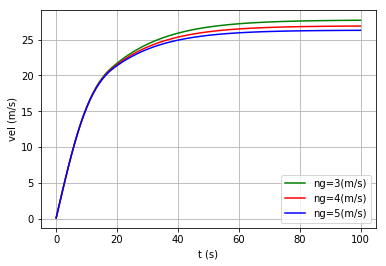

In [45]:
g1=plt.plot(t0, acd1[:, 1], 'g', label='cd=0.8')
g2=plt.plot(t0, acd2[:, 1], 'r', label='cd=0.85')
g3=plt.plot(t0, acd3[:, 1], 'b', label='cd=0.89')

plt.legend(loc='best')
plt.xlabel('t (s)')
plt.ylabel('vel (m/s)')
plt.grid()
plt.show()

<div style="text-align: left">**Grafica 3. Variacion de velocidad maxima y distancia total para diferentes parametros de coeficiente de arrastre** </div>

<div style="text-align: justify">El coeficiente de arrastre tambien genera un impacto en el desempeño del kart. La variacion de velocidades tope al cambiar el valor del coeficiente entre 0.8 y 0.89 (valores reportados por Mariana) es de mas del 3%. Ciertamente no es tan importante como la relacion de transmision pero aun es importante tener en cuenta su efecto.</div>

### VARIACION DE PARAMETROS PARA EL KART PARA FRENADO ##

### MASA: ###


In [100]:
#masa= 152
#masa= 160
masa= 140
cd=0.89



In [97]:
x1=[np.max(integral[:,0]),np.max(integral[:,1])]
t0 = linspace(0, 100, 100)
am1=odeint(afrenado,x1,t0)

In [99]:
x1=[np.max(integral[:,0]),np.max(integral[:,1])]
t0 = linspace(0, 100, 100)
am2=odeint(afrenado,x1,t0)

In [101]:
x1=[np.max(integral[:,0]),np.max(integral[:,1])]
t0 = linspace(0, 100, 100)
am3=odeint(afrenado,x1,t0)

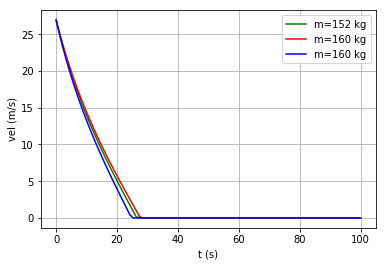

In [102]:
g1=plt.plot(t0, am1[:, 1], 'g', label='m=152 kg')
g2=plt.plot(t0, am2[:, 1], 'r', label='m=160 kg')
g3=plt.plot(t0, am3[:, 1], 'b', label='m=160 kg')

plt.legend(loc='best')
plt.xlabel('t (s)')
plt.ylabel('vel (m/s)')
plt.grid()
plt.show()

<div style="text-align: left">**Grafica 4. Variacion de velocidad maxima y modelo de frenado para diferentes parametros de masa** </div>



Como era de esperarse, y relacionandolo con el efecto de la masa en la aceleracion. La velocidad de frenado no cambia mucho y el tiempo que le tomo al kar en llegar de velocidad maxima a cero varia alrededor de 1 segundo variando 10 kg de masa.


### RELACION DE TRANSMISION ###

Debido a que el frenado se genera directamente en la parte trasera del kart, el modelo de frenado planteado no tiene en cuenta la relacion de transmision. Por lo tanto la variacion de este solo afecta a la aceleracion

### COEFICIENTE DE ARRASTRE ###

In [141]:
### COEFICIENTE DE ARRASTRE ###
masa= 152
#cd= 0.8
#cd= 0.85
cd=0.89

x0 =[0,0.1]
t0 = linspace(0, 100, 100)
am=odeint(a,x0,t0)


In [138]:
x1=[np.max(am[:,0]),np.max(am[:,1])]
t1 = linspace(0, 100, 100)
acd1=odeint(afrenado,x1,t1)

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [140]:
x1=[np.max(am[:,0]),np.max(am[:,1])]
t1 = linspace(0, 100, 100)
acd2=odeint(afrenado,x1,t1)

In [144]:
x1=[np.max(am[:,0]),np.max(am[:,1])]
t0 = linspace(0, 100, 100)
acd3=odeint(afrenado,x1,t1)

/Users/camilogarciatorres/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


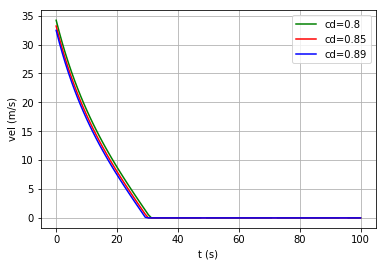

In [145]:
g1=plt.plot(t0, acd1[:, 1], 'g', label='cd=0.8')
g2=plt.plot(t0, acd2[:, 1], 'r', label='cd=0.85')
g3=plt.plot(t0, acd3[:, 1], 'b', label='cd=0.89')

plt.legend(loc='best')
plt.xlabel('t (s)')
plt.ylabel('vel (m/s)')
plt.grid()
plt.show()

<div style="text-align: left">**Grafica 5. Variacion de velocidad maxima y modelo de frenado para diferentes parametros de coeficiente de arrastre** </div>



<div style="text-align: justify"> Comparandola con el efecto que tuvo en el modelo de aceleracion, sorprendentemente el cambio de coeficiente de arrastre no afecta el desempeño del Kart. Entre las razones que podrian explicar este fenomeno es que en el modelo de aceleracion, la fuerza que mas disminuye la fuerza generada por el torque es la de arrastre. Por el contraraio, en el modelo de frenado todas las fuerzas son negativas y ayudan a frenas y en este caso la fuerza de frenado debe tener mucho mayor peso que la de arrastre</div>

## Comentarios finales analisis ##

- Lo primero que se debe resaltar es que hubo un problema inicial con la funcion de potencia de Clavijo. La grafica resultante no coincide con la ecuacion reportada. Es por esto que se ajusto la ecuacion a los datos. La ecuacion usada elimina la constante multiplicativa (3.037) y cambia la constante final que suma la ecuacion (de -1.89 a 12.89).

- La velocidad maxima de clavijo estuvo cerca al valor de 17 m/s segundo, mientras que el modelo analizado fue de 29.14 m/s, la diferencia se puede explicar probablemente debido a el cambio en la funcion de potencia utilizada por clavijo, ademas se utilizo la relacion de transmicion reportada por mariana. La velocidad maxima de mariana estuvo alrededor de los 25m/s. El error relativo entre las velocidad debido al cambio de funcion esta alrededor del 16%, lo cual es una diferencia significativa. Este error puede ser tambien debido al cambio de la funcion de potencia de clavijo 

- La fuerza de frenado utilizada es de 125 N. Utilizando un torque de 17 Nm que es valor  entregado por el motor en el frenado. En general un mayor torque genera un frenado mas rapido.

- El valor de la relacion de transmicion y eficiencia de transmision afectan notablemente el desempeno del carro. Una mayor relacion de transmicion y eficiencia generaran una velocidad maxima mayor. En el caso de la funcion aceleraryfrenar() se utilizo la relacion y eficiencia de Mariana Cordoba.


## Conclusiones ##
- El vector linspace afecta la precision de la funcion aceleraryfrenar(), al principio el tiempo total del recorrido no coincidia con la grafica. Se recomienda que el numero de partes en la que se divida el vector sea un numero grande. Para mi funcion, en el recorrido se uso una distancia de 5 segundo entre cada periodo de tiempo y el vector fue dividido en 100 partes. 

- La relacion de transimicion y eficiencia afecta la aceleracion del Kart. Por otro lado, el frenado del Kart no tiene en cuenta estas perdidas, y debido a que las fuerzas son todas negativas, esto genera la respuesta de una aceleracion de frenado mucho mas grande a la acelaracion hasta llegar a velocidad maxima.

- El cambio de funcion de potencia genero una velocidad maxima de 29 m/s aproximadamente. Mas rapido que las velocidades de mariana y clavijo.

- La distancia recorrida por el kart es alrededor de 3 km. Una distancia un poco larga para alcanzar velocidad maxima y volver a llegar a velociad cero 

- En aceleracion, la relacion de transimicion es la variable con mas efecto en la aceleracion del kart, con un aumento de velocidad de hasta 3 m/s por unidad. Le sigue el coeficiente de arrastre con cambio de velocidad pico de 1 a 0.5 m/s y por ultimo la masa que no afecto mucho el rendimiento del carro

- Al contrario de lo esperado, el coeficiente de friccion tiene un efecto bajo en el modelo de frenado del kart. La otra variable analizada que es la masa tampoco tiene un efecto significativo en el frenado. Por ultimo, la relacion de transmision no importa en el frenado ya que la fuerza se aplica en las llantas traseras.